In [1]:
import pandas as pd
import xmltodict 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

import plotly.offline as pyo
import plotly.express as px


# Set notebook mode to work in offline
pyo.init_notebook_mode(connected=True)

# How many calories will I burn if I go from Utrecht to Brussels by bike? 

# Introduction

I decided to take the data from my watch rather quickly. I use it every day. I love this tool. I asked myself what I could do with 1 year of data.

I took the data from the 2021-03-06 to the 2022-05-11.

Then I decided to go to Brussel on the 27 of Mai. That day I ate a lot, because 180km is long.

But with all the data recorded before, could I have predicted the number of calories spent and the time on the bike to do 180km? for example, to optimize my nutrition.

And as I managed to go to Brussel by bike I will also be able to compare and discuss the predicted value and the real value!



# Data set and Apple Wash

When you request the data in your health application. You receive a compressed xml file. Then my goal was to get dataframes from this xml file.

In [2]:
input_path = 'export.xml'
with open(input_path, 'r') as xml_file:
    input_data = xmltodict.parse(xml_file.read())
#Records list for general health data & imported as Pandas Data Frame
records_list = input_data['HealthData']['Record']
df_records = pd.DataFrame(records_list)
#Workout list for workout data
workouts_list = input_data['HealthData']['Workout']
df_workouts = pd.DataFrame(workouts_list)

#Towards Data Science's code (1)

Scrapping this data wasn't very challenging however I already scrape online market in project 1, html tables in dataplayground, and use API in project 2 so it was nice to discover xml export and how to work with it. 

In [3]:
df_workouts.head()  #overview of the export in a dataframe 

,@workoutActivityType,@duration,@durationUnit,@totalDistance,@totalDistanceUnit,@totalEnergyBurned,@totalEnergyBurnedUnit,@sourceName,@sourceVersion,@creationDate,@startDate,@endDate,MetadataEntry,@device,WorkoutEvent,WorkoutRoute
0,HKWorkoutActivityTypeCycling,90.87145182291667,min,28.572669921875,km,726,kcal,Connect,1,2020-05-21 12:36:21 +0200,2020-05-17 14:30:03 +0200,2020-05-17 16:00:55 +0200,"{'@key': 'HKIndoorWorkout', '@value': '0'}",NaN,NaN,NaN
1,HKWorkoutActivityTypeCycling,31.13196614583333,min,10.923419921875,km,308,kcal,Connect,1,2020-06-18 19:20:57 +0200,2020-05-19 19:56:54 +0200,2020-05-19 20:28:01 +0200,"{'@key': 'HKIndoorWorkout', '@value': '0'}",NaN,NaN,NaN
2,HKWorkoutActivityTypeCycling,110.1818033854167,min,37.6965,km,1040,kcal,Connect,1,2020-06-19 11:45:20 +0200,2020-05-21 10:43:19 +0200,2020-05-21 12:33:29 +0200,"{'@key': 'HKIndoorWorkout', '@value': '0'}",NaN,NaN,NaN
3,HKWorkoutActivityTypeCycling,27.34184977213542,min,8.905269531249999,km,241,kcal,Connect,1,2020-06-21 17:00:25 +0200,2020-05-22 16:07:26 +0200,2020-05-22 16:34:46 +0200,"{'@key': 'HKIndoorWorkout', '@value': '0'}",NaN,NaN,NaN
4,HKWorkoutActivityTypeCycling,28.68728434244792,min,11.5847998046875,km,358,kcal,Connect,1,2020-06-21 17:00:25 +0200,2020-05-22 20:38:36 +0200,2020-05-22 21:07:17 +0200,"{'@key': 'HKIndoorWorkout', '@value': '0'}",NaN,NaN,NaN


In [4]:
df_records.head() #overview of the export in a dataframe 

,@type,@sourceName,@sourceVersion,@unit,@creationDate,@startDate,@endDate,@value,MetadataEntry,@device,HeartRateVariabilityMetadataList
0,HKQuantityTypeIdentifierHeight,SantÃ©,12.4.1,cm,2020-03-12 18:35:08 +0200,2020-03-12 18:35:08 +0200,2020-03-12 18:35:08 +0200,187,NaN,NaN,NaN
1,HKQuantityTypeIdentifierBodyMass,SantÃ©,12.4.1,kg,2020-03-12 18:35:08 +0200,2020-03-12 18:35:08 +0200,2020-03-12 18:35:08 +0200,80,NaN,NaN,NaN
2,HKQuantityTypeIdentifierBodyMass,Connect,1,kg,2020-06-17 09:44:12 +0200,2020-05-18 00:00:00 +0200,2020-05-18 00:00:00 +0200,77,NaN,NaN,NaN
3,HKQuantityTypeIdentifierBodyMass,Connect,21,kg,2020-08-06 14:41:49 +0200,2020-07-11 00:00:00 +0200,2020-07-11 00:00:00 +0200,76,NaN,NaN,NaN
4,HKQuantityTypeIdentifierBodyMass,iPhone de Etienne,14.4,kg,2021-03-06 13:26:24 +0200,2021-03-06 13:26:24 +0200,2021-03-06 13:26:24 +0200,79,NaN,NaN,NaN


So I have now two datasets. 

One only for workouts. workouts_df

One for everything. records_df

##### CLEANING df_workouts Steps : 

1 - Dtype 


2 - Unit Columns 

3 - Delete useless columns 

4 - Rename Columns 

5 - Rename acitivity Type

In [5]:
#df_workouts[["@duration", "@totalDistance", "@totalEnergyBurned"]] = df_workouts[["@duration", "@totalDistance", "@totalEnergyBurned"]].apply(pd.to_numeric)
#df_workouts.dtypes


#I used apply to numeric cause these variables were objects before. 


#Now dates variables  are object so I need first to creat a variable format. Then I use the function to_datetime.
#format = '%Y-%m-%d %H:%M:%S %z'
#df_workouts['@startDate'] = pd.to_datetime(df_workouts['@startDate'], format=format)
#df_workouts['@startDate'] = pd.to_datetime(df_workouts['@startDate'], format=format)
#df_workouts['@endDate'] = pd.to_datetime(df_workouts['@endDate'], format=format)
#df_workouts['@creationDate'] = pd.to_datetime(df_workouts['@creationDate'], format = format)
#df_workouts.dtypes

#Columns selection 
#df_workouts = df_workouts.iloc[:,0:12]
#del df_workouts['@sourceName']
#del df_workouts['@sourceVersion']
#del df_workouts['@durationUnit']
#del df_workouts['@totalDistanceUnit']
#del df_workouts['@totalEnergyBurnedUnit']

#rename
#df_workouts.rename(columns = {'@duration':'Duration(min)', '@totalDistance':'totalDistance(km)','@totalEnergyBurned':'totalEnergyBurned(kcal)','@creationDate':'creationDate','@startDate':'startDate','@endDate':'endDate','@workoutActivityType':'ActivityType'}, inplace = True)

#rename unique variable in the column "Activity Type"
#df_workouts["ActivityType"]= df_workouts["ActivityType"].replace("HKWorkoutActivityTypeCycling", "Cycling") 
#df_workouts["ActivityType"]= df_workouts["ActivityType"].replace("HKWorkoutActivityTypeRunning", "Running") 
#df_workouts["ActivityType"]= df_workouts["ActivityType"].replace("HKWorkoutActivityTypeWalking", "Walking") 
#df_workouts["ActivityType"]= df_workouts["ActivityType"].replace("HKWorkoutActivityTypeFunctionalStrengthTraining", "StrengthTraining") 
#df_workouts["ActivityType"]= df_workouts["ActivityType"].replace("HKWorkoutActivityTypeSwimming", "Swimming") 
#df_workouts["ActivityType"]= df_workouts["ActivityType"].replace("HKWorkoutActivityTypeYoga", "Yoga") 
#df_workouts["ActivityType"]= df_workouts["ActivityType"].replace("HKWorkoutActivityTypePaddleSports", "Kayak")

# Feature engineering

Let's create a speed variable

In [6]:
#df_workouts['hour1'] = df_workouts['startDate'].dt.time df_workouts['hour2'] = df_workouts['endDate'].dt.time

#df_workouts["deltaT(h)"] = df_workouts["Duration(min)"]/60

#df_workouts["averageSpeed(km/h)"] = df_workouts['totalDistance(km)']/df_workouts["deltaT(h)"]

Let's create a BMI variable

In [7]:
#Height = df_records[df_records['@type'] == 'HKQuantityTypeIdentifierHeight']
#Height = Height[["@value","@startDate",'@endDate']] 
#Height.rename(columns = {'@value':'Height(cm)','@startDate':'startDate','@endDate':'endDate'}, inplace = True)
#format = '%Y-%m-%d %H:%M:%S %z' 
#Height['startDate'] = pd.to_datetime(Height['startDate'], format=format) 
#Height['endDate'] = pd.to_datetime(Height['endDate'], format=format) 
#Height['Height(cm)'] = Height['Height(cm)'].apply(pd.to_numeric) 

#Weight = df_records[df_records['@type'] == 'HKQuantityTypeIdentifierBodyMass'] Weight = Weight[["@value","@startDate",'@endDate']] Weight.rename(columns = {'@value':'Weight(kg)','@startDate':'startDate','@endDate':'endDate'}, inplace = True) format = '%Y-%m-%d %H:%M:%S %z' Weight['startDate'] = pd.to_datetime(Weight['startDate'], format=format) Weight['endDate'] = pd.to_datetime(Weight['endDate'], format=format) Weight['Weight(kg)'] = Weight['Weight(kg)'].apply(pd.to_numeric) Weight.head()

#df = pd.concat([Weight,Height], ignore_index=True)

#df['Heihgt(cm)'] = df['Height(cm)'].fillna(187) df.head()

#newdf = pd.concat([df_workouts, df ])

In [8]:
#df_workouts['Weight(kg)'] = 0

#poids1time = df_workouts.loc[(df_workouts['startDate'] > '2020-03-12 18:35:08+02:00') & (df_workouts['startDate'] < '2020-05-18 00:00:00+02:00')] 
#poids2time = df_workouts.loc[(df_workouts['startDate'] > '2020-05-18 00:00:00+02:00') & (df_workouts['startDate'] < '2020-07-11 00:00:00+02:00')]
#poids3time = df_workouts.loc[(df_workouts['startDate'] > '2020-07-11 00:00:00+02:00') & (df_workouts['startDate'] < '2021-03-06 13:26:24+02:00')]
#poids4time = df_workouts.loc[(df_workouts['startDate'] > '2021-03-06 13:26:24+02:00') & (df_workouts['startDate'] < '2022-03-08 10:34:00+02:00')]
#poids5time = df_workouts.loc[(df_workouts['startDate'] >= '2022-03-08 10:34:00+02:00')]

#poids1time["Weight(kg)"] = 80 
#poids2time["Weight(kg)"] = 77
#poids3time["Weight(kg)"] = 76 
#poids4time["Weight(kg)"] = 79 
#poids5time["Weight(kg)"] = 82


#frames allows me to concat without problem of index. 
#frames = [poids1time, poids2time, poids3time, poids4time, poids5time]

#finaldf = pd.concat(frames, sort=False)

#finaldf

#finaldf['Height(cm)'] = 187

#finaldf["BMI"] = finaldf["Weight(kg)"]/((finaldf["Height(cm)"]/100)**2) finaldf = finaldf[["ActivityType","Duration(min)","totalDistance(km)","totalEnergyBurned(kcal)","averageSpeed(km/h)","BMI"]] 

#finaldf.to_csv("activity.csv")

In [9]:
df1 = pd.read_csv("activity.csv")

#Now for my study I don't need all the unique variable inside the column Activity Type. 
del df1['Unnamed: 0'] 
df1 = df1[df1['ActivityType'] != 'StrengthTraining']
df1 = df1[df1['ActivityType'] != 'Walking']
df1 = df1[df1['ActivityType'] != 'Yoga']
df1 = df1[df1['ActivityType'] != 'Kayak']
df1 = df1[df1['ActivityType'] != 'Swimming']
df1 = df1[df1['ActivityType'] != 'Running']
df1 = df1.dropna()
df1['ActivityType'].unique()
df1

,ActivityType,Duration(min),totalDistance(km),totalEnergyBurned(kcal),averageSpeed(km/h),BMI
0,Cycling,90.871452,28.572670,726.000000,18.865773,22.877406
1,Cycling,31.131966,10.923420,308.000000,21.052483,22.019503
2,Cycling,110.181803,37.696500,1040.000000,20.527800,22.019503
3,Cycling,27.341850,8.905270,241.000000,19.542064,22.019503
4,Cycling,28.687284,11.584800,358.000000,24.229829,22.019503
...,...,...,...,...,...,...
937,Cycling,50.593861,20.186837,505.113894,23.939866,23.449341
938,Cycling,16.308763,4.551423,75.102000,16.744703,23.449341
939,Cycling,16.103479,4.541209,75.988000,16.920103,23.449341
940,Cycling,58.247580,23.191472,563.620278,23.889204,23.449341


# Exploratory data analysis

Explore your data set with the research question in mind. Present relevant graphs, tables and numbers with respect to your problem.

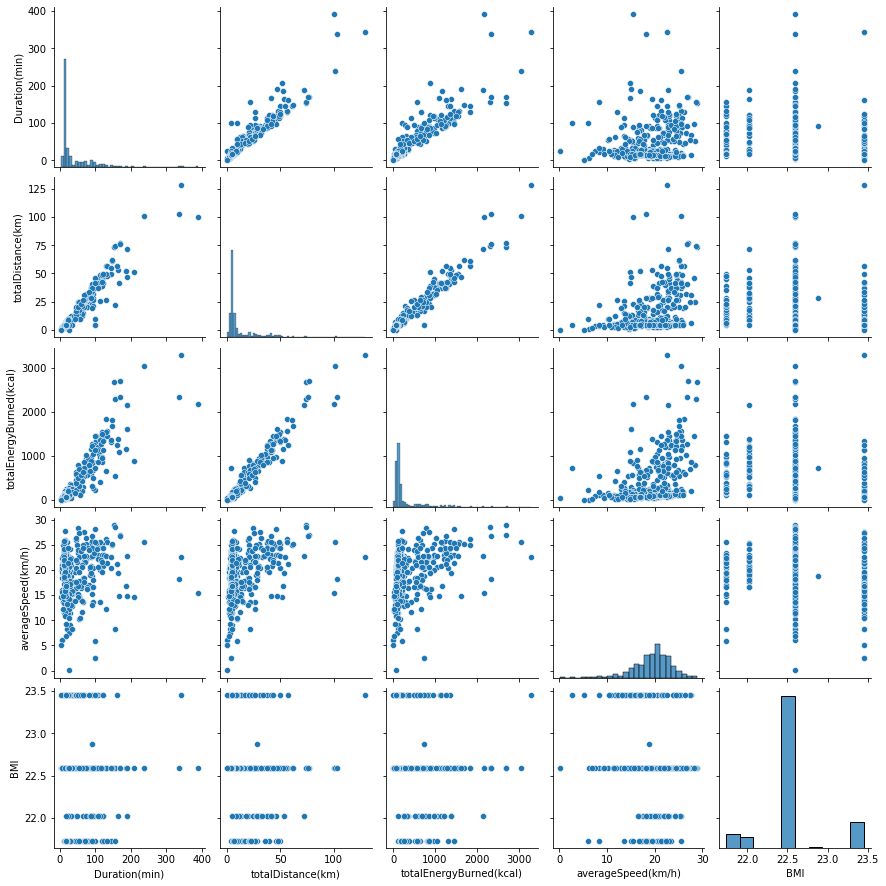

In [10]:
sns.pairplot(df1)
plt.show()

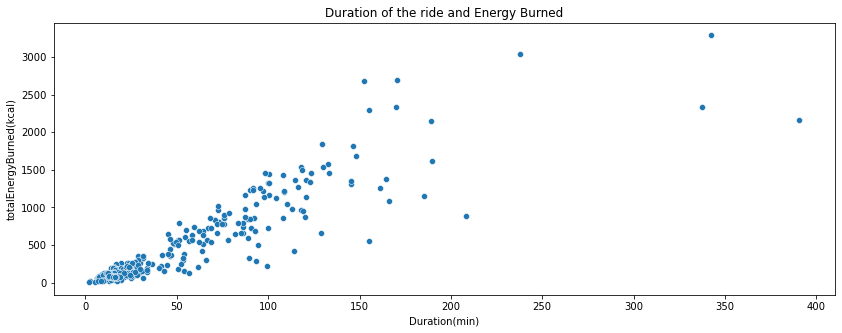

In [11]:
#figure2 = px.scatter(
      #  df1, 
     #   x = "Duration(min)",
    #    y= "totalEnergyBurned(kcal)",
   #     title = "Duration of the ride and Energy Burned",
  #      template = "presentation",
 #       )
#figure2.show()

plt.figure(figsize=(14, 5))
sns.scatterplot(data=df1,
                x = "Duration(min)",
                y = "totalEnergyBurned(kcal)"
               )

plt.title("Duration of the ride and Energy Burned")
plt.show()

The model seems to fit a linear pattern with some outliers. 

There may not be enough training that lasts more than 200 minutes.

The model is probably not as linear as that. The longer the training the less intensive it is. So you burn a lot of calories, but not as fast as on workouts of less than 60 minutes.

A study should have been done with cardiac variation. Instead I could take the average speed. Which is a good way to show the intensity. If the playing field and the bike is the same. Which is not the case in this sample. Riding in the mud or riding in a flat country is very different.

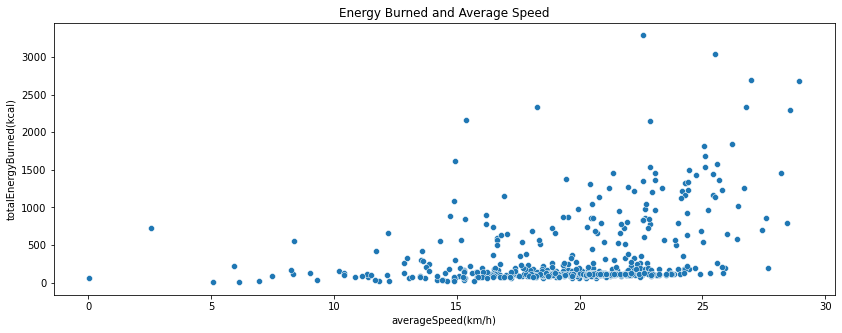

In [12]:
#figure3 = px.scatter(
     #   df1, 
    #    y = "totalEnergyBurned(kcal)",
   #     x = "averageSpeed(km/h)",
  #      title = "Energy Burned and Average Speed ",
 #       template = "presentation",
       # )
#figure3.show()

plt.figure(figsize=(14, 5))
sns.scatterplot(data=df1,
                x = "averageSpeed(km/h)",
                y = "totalEnergyBurned(kcal)"
               )

plt.title("Energy Burned and Average Speed")
plt.show()

This graph is not linear at all. As I said before there is too much factor to the average speed. It's not just about intensity and heart rate

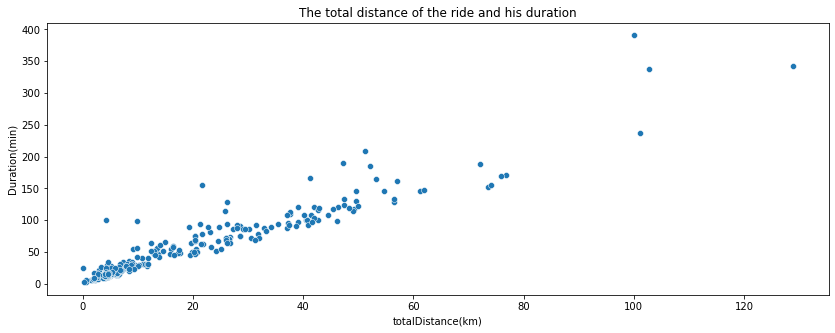

In [13]:
#figure4 = px.scatter(
      #  df1, 
     #   y = "Duration(min)",
    #    x = "totalDistance(km)",
   #     title = "The total distance of the ride and his duration",
  #      template = "presentation",
 #       )
#figure4.show()


plt.figure(figsize=(14, 5))
sns.scatterplot(data=df1,
                x="totalDistance(km)",
                y = "Duration(min)"
               )

plt.title("The total distance of the ride and his duration")
plt.show()

This graph seems to show a very linear pattern. I think I can predict a correct value for the Utrecht - Brussels route!

# Predictive models

I suggest to do a linear regression to predict the duration of my ride Utrecht Brussel and then try a multiple line regression to predict calories burned. 

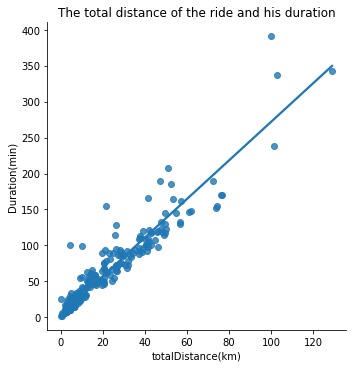

In [14]:
sns.lmplot(x='totalDistance(km)', y='Duration(min)', data=df1, ci=False) #ci means "confidence interval"
plt.title('The total distance of the ride and his duration')
plt.show()

We want now to determine the coefficients of the line.Let's use sk-learn.

In [15]:
from sklearn.linear_model import LinearRegression

x = df1[['totalDistance(km)']] #independant variable  
y = df1['Duration(min)'] #dependant variable
lm = LinearRegression() 
lm.fit(x, y) 

b0 = lm.intercept_  #intercept represents the value of y when x is 0
b1 = lm.coef_[0] #slope coeficient 

print(f"The regression line is equal to y = {b0:.3f} + {b1:.3f}X") 

The regression line is equal to y = 3.698 + 2.685X


$y= 3.698 + 2.685x$

There are 175km between Utrecht and Brussels

$f(175)= 3.698 + 2.685*175$

$f(175)= 473,573$

The model predict a faster time than I did (504 minutes). 

In [16]:
df1['Duration(min)_p'] = lm.predict(x) #use built-in predict() method to generate predictions; store in original dataframe
df1.head(10)

,ActivityType,Duration(min),totalDistance(km),totalEnergyBurned(kcal),averageSpeed(km/h),BMI,Duration(min)_p
0,Cycling,90.871452,28.572670,726.0,18.865773,22.877406,80.401757
1,Cycling,31.131966,10.923420,308.0,21.052483,22.019503,33.021872
2,Cycling,110.181803,37.696500,1040.0,20.527800,22.019503,104.894924
3,Cycling,27.341850,8.905270,241.0,19.542064,22.019503,27.604093
4,Cycling,28.687284,11.584800,358.0,24.229829,22.019503,34.797364
5,Cycling,86.214966,29.150439,745.0,20.286807,22.019503,81.952795
6,Cycling,64.238184,19.697660,513.0,18.398086,22.019503,56.576555
7,Cycling,120.447201,46.290988,1370.0,23.059559,22.019503,127.967058
8,Cycling,46.367834,13.594530,349.0,17.591329,22.019503,40.192539
9,Cycling,86.490031,30.111570,789.0,20.889046,22.019503,84.532976


Some predictions are right, some not so much!

Let's now work on calories. With multiple linear regression.

In [17]:
df1.corr()

,Duration(min),totalDistance(km),totalEnergyBurned(kcal),averageSpeed(km/h),BMI,Duration(min)_p
Duration(min),1.000000,0.958182,0.914008,0.119973,-0.110866,0.958182
totalDistance(km),0.958182,1.000000,0.978819,0.315404,-0.108086,1.000000
totalEnergyBurned(kcal),0.914008,0.978819,1.000000,0.351433,-0.143733,0.978819
averageSpeed(km/h),0.119973,0.315404,0.351433,1.000000,-0.172220,0.315404
BMI,-0.110866,-0.108086,-0.143733,-0.172220,1.000000,-0.108086
Duration(min)_p,0.958182,1.000000,0.978819,0.315404,-0.108086,1.000000


1–0.8 → Very strong

0.799–0.6 → Strong

0.599–0.4 → Moderate

0.399–0.2 → Weak

0.199–0 → Very Weak

In [18]:
from scipy.stats.stats import pearsonr
print(pearsonr(df1['totalEnergyBurned(kcal)'],df1['Duration(min)']))
print(pearsonr(df1['totalEnergyBurned(kcal)'],df1['totalDistance(km)']))

(0.914008163765792, 1.3256977968818672e-199)
(0.9788188760015909, 0.0)


p < 0 ("A low p-value shows that the effect is large or that the result is of major theoretical, clinical or practical importance.")

A p-value higher than 0.05 (> 0.05) is not statistically significant and indicates strong evidence for the null hypothesis. This means we retain the null hypothesis and reject the alternative hypothesis. You should note that you cannot accept the null hypothesis, we can only reject the null or fail to reject it.

##### Dependant variable ?

In [19]:
y = df1['totalEnergyBurned(kcal)'] 
y.dropna(inplace=True)
y.head()

0     726.0
1     308.0
2    1040.0
3     241.0
4     358.0
Name: totalEnergyBurned(kcal), dtype: float64

##### independant variable ?

In [20]:
X = df1[['totalDistance(km)','Duration(min)']]
X.head()

,totalDistance(km),Duration(min)
0,28.57267,90.871452
1,10.92342,31.131966
2,37.69650,110.181803
3,8.90527,27.341850
4,11.58480,28.687284


 Now that we have our dependant and independants values, let's split the data into a training set and a test set.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 
X_train.head() 

,totalDistance(km),Duration(min)
13,24.710430,89.005835
70,6.246100,16.766667
705,4.529225,12.687909
39,28.593230,75.694132
685,21.413135,62.236906


let's see how the linear model is working 

In [22]:
lm = LinearRegression() 
model = lm.fit(X_train, y_train) 

In [23]:
coef = pd.DataFrame(X.columns.values, lm.coef_) 
coef

,0
39.563818,totalDistance(km)
-4.204279,Duration(min)


Each km it'as add 39kcal and each minutes it removes 4kcal. 

In [24]:
intercept = lm.intercept_
intercept

1.4505593427305712

#### FUNCTION TIME

#### Towards Data Science's code (4)

$Y’i = b0 + b1X1i + b2X2i$

b0 = 1,45

b1 = 39,56 (distance)
B2 = -4,20 (duration)

$Y = 1,45 + 39,56x1- 4,20x2$

So how many calories for 
504 minutes
175,97km

$Y = 1,45 + 39,56*(175,97)- 4,20*(504)$
$Y = 1,45 + 6961,37 - 2116,8)$
$Y = 4846,02$

Kcal activity : 3829
Total Kcal 4706, This is not about this data cause I check my apple health app and the  dataset. 

my y variable is total energy burned(kcal) during the activity 

There is thus a big difference, lets evaluate the performance. 

#### Another way to evaluate the performance of our modele

How to look at the model performance ? 

We need to generate predictions and calculate the R^2 and RMSE.

In [25]:
y_test_p = lm.predict(X_test) 
r2_score(y_test, y_test_p)

0.8934303069169048

The R^2 is 0.89, which means 89% of the variation in kcal is explained by the model. 

now we have to calculate : RMSE : root mean square error

In [26]:
math.sqrt(mean_squared_error(y_test, y_test_p))

109.21938846055336

We have errors of + or - 109 kcal. 

C:\Users\etien\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



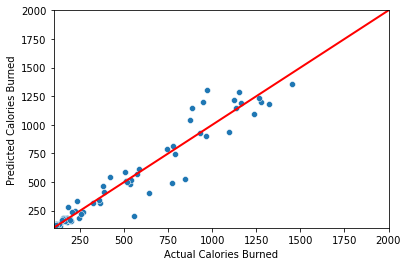

In [27]:
sns.scatterplot(y_test, y_test_p)
plt.xlabel('Actual Calories Burned')
plt.ylabel('Predicted Calories Burned')
plt.xlim([100,2000]) 
plt.ylim([100,2000])
plt.plot([100, 2000], [100, 2000], color='red', lw=2) 
plt.show()

The model is doing a fine job. 

Perhaps there are errors to predict correctly this activity Utrecht - Brussels because I wasn't alone. Also we did lots of breaks. So I think Utrecht - Brussels activivity would have been an outlier in this chart. 

# Conclusion

I read this very interesting study recently. About the way the apple watch calculates the calories spent in activity. The study concludes that the calculations are poor. 

"We assessed, in a controlled laboratory setting, the reliability of seven wrist-worn devices in a diverse group of individuals performing walking, running and cycling at low and high intensity. We found that in most settings, heart rate measurements were within acceptable error range (5%). In contrast, none of the devices provided estimates of energy expenditure that were within an acceptable range in any setting. Individuals and practitioners should be aware of the strengths and limitations of consumer devices that measure heart rate and estimate energy expenditure."

https://www.mdpi.com/2075-4426/7/2/3/htm


Nevertheless we can always predict. The predictions are good in relation to this calorie calculation model. 

In these predictions we have seen that Utrecht Brussel activity is an outlier. 

Brussels Journey data : 

Duration : 504 minutes
Predicted duration : 473 minutes

Kcal activity : 3829
Predicted Kcal activity  : 4846,02

# Bonus data learning visualization, Daily BPM average along the year

I wanted to work with workouts, and heart rates, sadly I did'nt manage to link in the same dataframe. So I decided to make a cool graphic. Where we can visualize and learn a lot from it. 

I was browsing the reddit named "dataisbeautiful". And I saw this pretty funny post : https://www.reddit.com/r/dataisbeautiful/comments/p5o7wo/oc_my_average_heart_rate_along_the_day_data/

reddit's inspirations (3)

With this kind of graphic you could know so much about the author of the publication. So I wanted to try the method on myself. There was no source code provided so it was a nice challenge. In particular the for loop!

Get the heart rates values. references(2)

In [28]:
import re
import csv

file_name = 'export.xml'
pattern = '^.*IdentifierHeartRate".*startDate="(.{19}).*value="([0-9]*).*$'

with open('hr_export.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['dt', 'bpm'])

    with open(file_name, 'r') as f2:
        for line in f2:
            search = re.search(pattern, line)
            if search is not None:
                writer.writerow([search.group(1), search.group(2)])
                
dfhr = pd.read_csv("hr_export.csv")
dfhr.head()

#github's code (2)

,dt,bpm
0,2021-03-06 13:27:34,88
1,2021-03-06 13:32:23,67
2,2021-03-06 13:38:29,74
3,2021-03-06 13:38:34,75
4,2021-03-06 13:38:39,74


#### cleaning : 

So we need to clean these values. 

Dates need to be numbers to subset them.

Then I can find average heart bpm each day of the week over each time interval 

I want to know for exemple : how many heart bpm on mondays between 8 and 8:30

Obtain Heart Rate values (Applewash's notebook) file : "hr_export.csv", title : "Getting BPM values"

Creation of daily average (Cleaning Data2's notebook) thanks to a for loop and those functions : deltatime, datetime, between_time, strftime...

In [29]:
import datetime
dfhr = pd.read_csv("hr_export.csv")
dfhr['dt'] = pd.to_datetime(dfhr['dt'])
dfhr['day_of_week_in_number'] = dfhr['dt'].dt.dayofweek

dfhr

,dt,bpm,day_of_week_in_number
0,2021-03-06 13:27:34,88,5
1,2021-03-06 13:32:23,67,5
2,2021-03-06 13:38:29,74,5
3,2021-03-06 13:38:34,75,5
4,2021-03-06 13:38:39,74,5
...,...,...,...
251242,2022-05-11 11:53:48,69,2
251243,2022-05-11 11:56:45,67,2
251244,2022-05-11 12:07:42,76,2
251245,2022-05-11 12:04:42,67,2


In [30]:
mondaydf = dfhr[dfhr['day_of_week_in_number']==0]
#mondaydf
tuesdaydf = dfhr[dfhr['day_of_week_in_number']==1]
#tuesdaydf
wednesdaydf = dfhr[dfhr['day_of_week_in_number']==2]
#wednesdaydf

thursdaydf = dfhr[dfhr['day_of_week_in_number']==3]
#thursdaydf

fridaydf = dfhr[dfhr['day_of_week_in_number']==4]
#fridaydf

saturdaydf = dfhr[dfhr['day_of_week_in_number']==5]
#saturdaydf

sundaydf = dfhr[dfhr['day_of_week_in_number']==6]
sundaydf

,dt,bpm,day_of_week_in_number
252,2021-03-07 00:00:52,102,6
253,2021-03-07 00:06:39,102,6
254,2021-03-07 00:12:38,83,6
255,2021-03-07 00:20:31,94,6
256,2021-03-07 00:23:49,92,6
...,...,...,...
248847,2022-01-09 13:05:59,130,6
249322,2022-01-09 19:03:07,152,6
249323,2022-01-09 19:14:40,155,6
249324,2022-01-09 19:24:35,158,6


In [31]:
mondaydf.set_index('dt', inplace=True)  
mondaydf.index = pd.to_datetime(mondaydf.index)    
df2 = mondaydf.resample(rule = '30Min').mean()

tuesdaydf.set_index('dt', inplace=True)  
tuesdaydf.index = pd.to_datetime(tuesdaydf.index)    
df3 = tuesdaydf.resample(rule = '30Min').mean()

wednesdaydf.set_index('dt', inplace=True)  
wednesdaydf.index = pd.to_datetime(wednesdaydf.index)    
df4 = wednesdaydf.resample(rule = '30Min').mean()


thursdaydf.set_index('dt', inplace=True)  
thursdaydf.index = pd.to_datetime(thursdaydf.index)    
df5 = thursdaydf.resample(rule = '30Min').mean()


fridaydf.set_index('dt', inplace=True)  
fridaydf.index = pd.to_datetime(fridaydf.index)    
df6 = fridaydf.resample(rule = '30Min').mean()


saturdaydf.set_index('dt', inplace=True)  
saturdaydf.index = pd.to_datetime(saturdaydf.index)    
df7 = saturdaydf.resample(rule = '30Min').mean()

sundaydf.set_index('dt', inplace=True)  
sundaydf.index = pd.to_datetime(sundaydf.index)    
df8 = sundaydf.resample(rule = '30Min').mean()

exemple of the thursdayloop

In [32]:
import datetime
from datetime import timedelta
box_list = []

def loop():
    for i in range(29):
        
        dep_time = datetime.datetime(year= 2021, month = 1, day = 1, hour = 7,minute = 0 )
        end_time = datetime.datetime(year= 2021, month = 1, day = 1, hour = 7,minute = 30 )
        x=0
        dep_time = dep_time + timedelta(minutes=30*i)
        end_time = end_time + timedelta(minutes=30*i)
        
        dep_time_str = dep_time.strftime("%H:%M")
        end_time_str = end_time.strftime("%H:%M")
        
        globals()[f"dfthursday{i}"] = df5.between_time(dep_time_str,end_time_str)

        globals()[f"dfthursday{i}"].dropna()
        globals()[f"AVGthursday{i}"] =  globals()[f"dfthursday{i}"]['bpm'].mean()
        box_list.append(globals()[f"AVGthursday{i}"])
        print(globals()[f"AVGthursday{i}"])
loop()

70.53879545354614
75.55378945214048
75.11253903117591
73.52333018888338
71.5159278099275
72.88903558434299
78.91294345844462
82.35261470275556
81.69792089762055
78.08113186105635
75.89742019358683
74.50318439367538
75.11461879508826
76.76130811720407
76.17414042150672
78.37166407438232
80.72499121065223
81.0232797396651
81.99081190100888
83.24111182793351
83.79264949419745
81.85155002403539
77.19576356532333
73.57771805526475
77.43595843751474
81.58442232287375
79.39247695174872
74.85536809538155
72.77657396459797


I repeated this loop for each day of the week 

In [33]:
#data = {
 #   "Monday":[AVGdfmonday25,AVGdfmonday0,AVGdfmonday830,AVGdfmonday8309,AVGdfmonday930,AVGdfmonday9301,AVGdfmonday1030,AVGdfmonday103011,AVGdfmonday1130,AVGdfmonday113012,AVGdfmonday1230,AVGdfmonday10,AVGdfmonday11,AVGdfmonday12,AVGdfmonday13,AVGdfmonday14,AVGdfmonday15,AVGdfmonday16,AVGdfmonday17,AVGdfmonday18,AVGdfmonday19,AVGdfmonday20,AVGdfmonday21,AVGdfmonday22,AVGdfmonday23,AVGdfmonday24,AVGdfmonday25,AVGdfmonday26],
  #  "Tuesday":[AVGdftuesday0,AVGdftuesday1,AVGdftuesday2,AVGdftuesday3,AVGdftuesday4,AVGdftuesday5,AVGdftuesday6,AVGdftuesday7,AVGdftuesday8,AVGdftuesday9,AVGdftuesday10,AVGdftuesday11,AVGdftuesday12,AVGdftuesday13,AVGdftuesday14,AVGdftuesday15,AVGdftuesday16,AVGdftuesday17,AVGdftuesday18,AVGdftuesday19,AVGdftuesday20,AVGdftuesday21,AVGdftuesday22,AVGdftuesday23,AVGdftuesday24,AVGdftuesday25,AVGdftuesday26,AVGdftuesday27],
   # "Wednesday":[AVGdfwednesday0, AVGdfwednesday1, AVGdfwednesday2, AVGdfwednesday3, AVGdfwednesday4, AVGdfwednesday5, AVGdfwednesday6, AVGdfwednesday7, AVGdfwednesday8, AVGdfwednesday9, AVGdfwednesday10, AVGdfwednesday11, AVGdfwednesday12, AVGdfwednesday13, AVGdfwednesday14, AVGdfwednesday15, AVGdfwednesday16, AVGdfwednesday17, AVGdfwednesday18, AVGdfwednesday19, AVGdfwednesday20, AVGdfwednesday21, AVGdfwednesday22, AVGdfwednesday23, AVGdfwednesday24, AVGdfwednesday25, AVGdfwednesday26, AVGdfwednesday27],
    #"Thursday":[boxlistdf.iloc[0][0],boxlistdf.iloc[0][1],boxlistdf.iloc[0][2],boxlistdf.iloc[0][3],boxlistdf.iloc[0][4], boxlistdf.iloc[0][5], boxlistdf.iloc[0][6], boxlistdf.iloc[0][7], boxlistdf.iloc[0][8],boxlistdf.iloc[0][9],boxlistdf.iloc[0][10],boxlistdf.iloc[0][11],boxlistdf.iloc[0][12],boxlistdf.iloc[0][13],boxlistdf.iloc[0][14], boxlistdf.iloc[0][15],boxlistdf.iloc[0][17],boxlistdf.iloc[0][18],boxlistdf.iloc[0][19],boxlistdf.iloc[0][20],boxlistdf.iloc[0][21], boxlistdf.iloc[0][22],boxlistdf.iloc[0][23],boxlistdf.iloc[0][24],boxlistdf.iloc[0][25],boxlistdf.iloc[0][26],boxlistdf.iloc[0][27],boxlistdf.iloc[0][28]],    
    #"Friday":[AVGfriday0, AVGfriday1, AVGfriday2 ,AVGfriday3 ,AVGfriday4, AVGfriday5,AVGfriday6, AVGfriday7, AVGfriday8, AVGfriday9, AVGfriday10, AVGfriday11, AVGfriday12, AVGfriday13, AVGfriday14, AVGfriday15, AVGfriday16, AVGfriday17, AVGfriday18, AVGfriday19, AVGfriday20, AVGfriday21, AVGfriday22, AVGfriday23, AVGfriday24, AVGfriday25, AVGfriday26, AVGfriday27],
    #"Saturday":[AVGsaturday0, AVGsaturday1, AVGsaturday2, AVGsaturday3, AVGsaturday4, AVGsaturday5, AVGsaturday6, AVGsaturday7, AVGsaturday8, AVGsaturday9, AVGsaturday10, AVGsaturday11, AVGsaturday12, AVGsaturday13, AVGsaturday14, AVGsaturday15, AVGsaturday16, AVGsaturday17, AVGsaturday18, AVGsaturday19, AVGsaturday20, AVGsaturday21, AVGsaturday22, AVGsaturday23, AVGsaturday24, AVGsaturday25, AVGsaturday26, AVGsaturday27],
    #"Sunday":[AVGsunday0, AVGsunday1, AVGsunday2, AVGsunday3, AVGsunday4, AVGsunday5, AVGsunday6, AVGsunday7, AVGsunday8, AVGsunday9, AVGsunday10, AVGsunday11, AVGsunday12, AVGsunday13, AVGsunday14, AVGsunday15, AVGsunday16, AVGsunday17, AVGsunday18, AVGsunday19, AVGsunday20, AVGsunday21, AVGsunday22, AVGsunday23, AVGsunday24, AVGsunday25, AVGsunday26, AVGsunday27],
#}
#df_ = pd.DataFrame(data, index=['07:00 - 07:30','07:30 - 08:00','08:00 - 08:30','08:30 - 09:00','09:00 - 09:30','09:30 - 10:00','10:00 - 10:30','10:30 - 11:00','11:00 - 11:30','11:30 - 12:00','12:00 - 12:30','12:30 - 13:00','13:00 - 13:30', '13:30 - 14:00', '14:00 - 14:30', '14:30 - 15:00', '15:00 - 15:30', '15:30 - 16:00', '16:00 - 16:30', '16:30 - 17:00','17:00 - 17:30', '17:30 - 18:00', '18:00 - 18:30', '18:30 - 19:00', '19:00 - 19:30', '19:30 - 20:00', '20:00 - 20:30','20:30 - 21:00'])

#print (df_)

#df_.to_csv("dailyaveragebpm.csv")

This how I made the dataframe after using the loop. I probably should have found an algorithmy to put the loop data inside a dataframe. 

In [34]:
df = pd.read_csv("dailyaveragebpm.csv")
df.rename(columns = {'Unnamed: 0':'Timetable'}, inplace = True)
df.head()

,Timetable,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,07:00 - 07:30,76.953186,75.629937,72.869896,70.538795,73.789930,79.825397,73.933333
1,07:30 - 08:00,75.190420,78.866566,74.074021,75.553789,73.713973,77.239683,73.927721
2,08:00 - 08:30,75.316913,79.369711,74.377885,75.112539,72.856131,73.267592,70.664467
3,08:30 - 09:00,79.388688,82.568168,76.065968,73.523330,75.347199,70.536829,69.032293
4,09:00 - 09:30,79.294305,79.075790,76.894798,71.515928,75.121305,71.839152,73.461501


# Graphic, Data visualization

figure1 = px.line(
        df, 
        x = "Timetable",
        y= ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
        title = "Daily BPM average along the year",
        template = "presentation",
        labels={"value": "BPM", "variable": "Days"}
        )
figure1.show()

I can't use plotly express on Jupyter Notebook offline so I need to work with sns.. 

In [35]:
df = df.melt(id_vars=['Timetable'], value_vars=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],  var_name='Days', value_name='heart beat')
df

,Timetable,Days,heart beat
0,07:00 - 07:30,Monday,76.953186
1,07:30 - 08:00,Monday,75.190420
2,08:00 - 08:30,Monday,75.316913
3,08:30 - 09:00,Monday,79.388688
4,09:00 - 09:30,Monday,79.294305
...,...,...,...
191,18:30 - 19:00,Sunday,80.537097
192,19:00 - 19:30,Sunday,77.860413
193,19:30 - 20:00,Sunday,77.697844
194,20:00 - 20:30,Sunday,75.748660


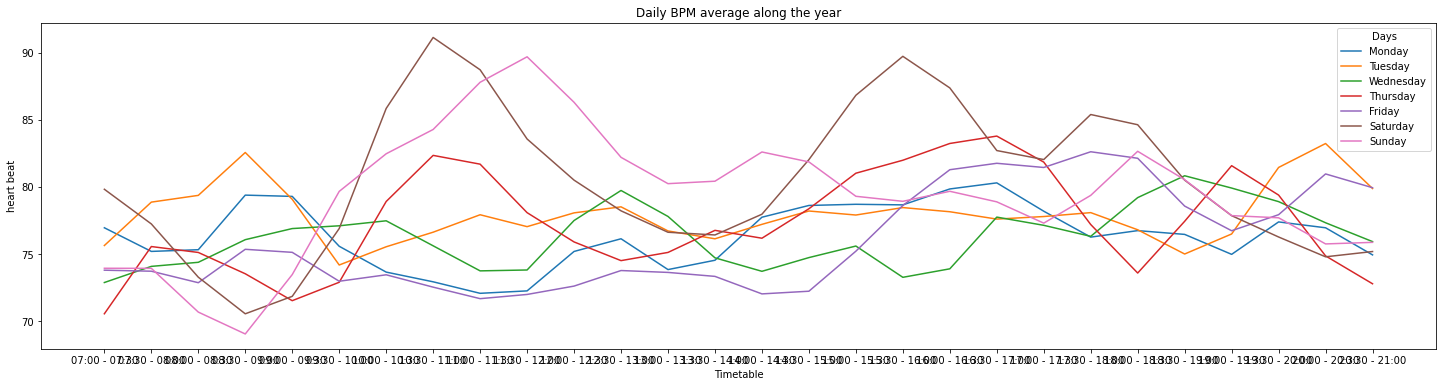

In [36]:
plt.figure(figsize=(25, 6))
sns.lineplot(data = df,
             x= "Timetable",
             y= "heart beat",
             hue = "Days"
             )

plt.title("Daily BPM average along the year")
plt.show()


What we learn from this graphic : 

I do sports during week ends and thursdays afternoon. 

I go to school by bike during the week. At this same time I am more sleepy during week end. 

I am going out on tuesday evenings.

# References/ Reaserch

https://towardsdatascience.com/data-analysis-of-your-applewatch-workouts-672fe0366e7c

flo.tausend. (Feb, 2020). Data Analysis Of Your AppleWatch Workouts - Towards Data Science.(code in image 1, and some cleaning tips)

https://github.com/minimaxir/get-heart-rate-csv/blob/master/hr_xml_to_csv.py

minimaxir. (Jan, 2018). Git Hub. (hr_xml_to_csv.py)

https://www.reddit.com/r/dataisbeautiful/comments/p5o7wo/oc_my_average_heart_rate_along_the_day_data/

calibri_light. (Sep, 2021) .Reddit's dataisbeautiful. (inspiration)


https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9

Adi Bronshtein. (May, 2017). Simple and Multiple Linear Regression in Python - Towards Data Science. (help me to do the multiple linear regression equations)

https://www.mdpi.com/2075-4426/7/2/3/htm

Shcherbina, A., Mattsson, C., Waggott, D., Salisbury, H., Christle, J., Hastie, T., Wheeler, M., & Ashley, E. (2017). Accuracy in Wrist-Worn, Sensor-Based Measurements of Heart Rate and Energy Expenditure in a Diverse Cohort. Journal of Personalized Medicine, 7(2), 3. https://doi.org/10.3390/jpm7020003

https://www.geeksforgeeks.org/data-visualization-using-matplotlib/

Jonas Moons. Canvas Data Learning, Teams's example. (linear_regression.ipynb, correlation.ipynb, multiple_linear_regression.ipynb)